<a href="https://colab.research.google.com/github/Jemka12/Caterpillar/blob/master/MoleModel_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем библиотеки и подготовляем среду

In [0]:
#ставим более старый PIL(с новым были проблемы)
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

In [0]:
#портируем библиотеки
import pickle
import numpy as np
import random

import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
#"Фиксируем" рандом.Для повторения решения
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
#подключаемся 
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#разорхивируем сет (если zip -> unzip)
!unrar x /content/gdrive/My\ Drive/skin-cancer-malignant-vs-benign_v1.rar  > /dev/null

# Подготовка датасета 


Для борьбой с переобучением добавлена аугментация 




In [0]:
#парочка глобальных переменных
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [0]:
#подготовка данных
class MoleDataset(Dataset):
  def __init__(self, files, mode, augmentations = None):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations
    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])
    #добавлена аугментация
    transform_train = transforms.Compose([
      transforms.ToPILImage(mode="RGB"),
      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
      transforms.RandomRotation(25),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)

    #в зависимости от режима работы - картинка обрабатывается по разному
    if self.mode == "train":
      x = transform_train(x)
    else:
      x = transform(x)

    if self.mode == 'test':
      return x
    else:
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

In [0]:
#сортируем датасеты
TRAIN_DIR = Path('data/train')
TEST_DIR = Path('data/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
#делим выборку на обучение и проверку

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)

# Функции обучения и предикт

1.   Изменен начальный lr ,для более глакого схождения градиента 
2.   Для тех же целей добавлен scheduler
3. Так же ,при достижении более высокого val_acc -> сохраняет веса модели


In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size):
    best_acc = 0
    
    #добавлен num_workers,для ускорения создания батча
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        #Изменен lr, добавлен scheduler
        opt = torch.optim.Adam(model.parameters(),lr=0.0001)
        scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.5)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # сохраняем веса лучшей модели 
            if  val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    # загружаем вес лучшей модели       
    model.load_state_dict(best_model_wts)       
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Обучение модели 


1.   Модель - resnet18 и второй вариант -  densnet121
2.   Изменен последний слой.Путем эксперементов ,более высокий скор достигла двухслойная модель 



In [0]:
# подготовляем датасет

val_dataset = MoleDataset(val_files, mode='val')
train_dataset = MoleDataset(train_files, mode='train')

In [0]:
#блок с densnet
model_extractor = models.densenet121(pretrained=True)
num_features = 1024
model_extractor.classifier = nn.Sequential(nn.Linear(num_features, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.BatchNorm1d(1024),
                                 nn.Linear(1024, 2))
model_extractor = model_extractor.cuda()

In [15]:
#блок с resnet
model_extractor = models.resnet18(pretrained=True)
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc   = nn.Sequential(nn.Linear(num_features, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.BatchNorm1d(1024),
                                 nn.Linear(1024, 2))
model_extractor = model_extractor.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 27.6MB/s]


In [29]:
#смотрим на нашу модель
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))
print(model_extractor)

we will classify :2
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [0]:
#запускаем train
history = train(train_dataset, val_dataset, model=model_extractor, epochs=40, batch_size=84)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

loss 0.5261324894622089


epoch:   2%|▎         | 1/40 [00:25<16:51, 25.93s/it]


Epoch 001 train_loss: 0.5261     val_loss 0.3391 train_acc 0.7350 val_acc 0.8485
loss 0.3795256580763716


epoch:   5%|▌         | 2/40 [00:51<16:21, 25.83s/it]


Epoch 002 train_loss: 0.3795     val_loss 0.2971 train_acc 0.8255 val_acc 0.8712
loss 0.3380076023621288


epoch:   8%|▊         | 3/40 [01:17<15:57, 25.88s/it]


Epoch 003 train_loss: 0.3380     val_loss 0.2813 train_acc 0.8461 val_acc 0.8649
loss 0.310884999550455


epoch:  10%|█         | 4/40 [01:42<15:25, 25.72s/it]


Epoch 004 train_loss: 0.3109     val_loss 0.2644 train_acc 0.8526 val_acc 0.8838
loss 0.28966903214047596


epoch:  12%|█▎        | 5/40 [02:07<14:53, 25.53s/it]


Epoch 005 train_loss: 0.2897     val_loss 0.2659 train_acc 0.8672 val_acc 0.8712
loss 0.27363478442033135


epoch:  15%|█▌        | 6/40 [02:33<14:29, 25.56s/it]


Epoch 006 train_loss: 0.2736     val_loss 0.2460 train_acc 0.8688 val_acc 0.8725
loss 0.2395637859658497


epoch:  18%|█▊        | 7/40 [02:59<14:03, 25.55s/it]


Epoch 007 train_loss: 0.2396     val_loss 0.2489 train_acc 0.8846 val_acc 0.8826
loss 0.2023287884951607


epoch:  20%|██        | 8/40 [03:24<13:34, 25.45s/it]


Epoch 008 train_loss: 0.2023     val_loss 0.2645 train_acc 0.9084 val_acc 0.8801
loss 0.1869789427131172


epoch:  22%|██▎       | 9/40 [03:49<13:08, 25.45s/it]


Epoch 009 train_loss: 0.1870     val_loss 0.2329 train_acc 0.9160 val_acc 0.9003
loss 0.18933696640216238


epoch:  25%|██▌       | 10/40 [04:15<12:42, 25.43s/it]


Epoch 010 train_loss: 0.1893     val_loss 0.2483 train_acc 0.9160 val_acc 0.8889
loss 0.1676312333926922


epoch:  28%|██▊       | 11/40 [04:40<12:17, 25.45s/it]


Epoch 011 train_loss: 0.1676     val_loss 0.2837 train_acc 0.9171 val_acc 0.8712
loss 0.1555415650935677


epoch:  30%|███       | 12/40 [05:06<11:52, 25.45s/it]


Epoch 012 train_loss: 0.1555     val_loss 0.2427 train_acc 0.9306 val_acc 0.9040
loss 0.16474231909203335


epoch:  32%|███▎      | 13/40 [05:31<11:26, 25.42s/it]


Epoch 013 train_loss: 0.1647     val_loss 0.2802 train_acc 0.9236 val_acc 0.8864
loss 0.13331250000775344


epoch:  35%|███▌      | 14/40 [05:56<11:00, 25.40s/it]


Epoch 014 train_loss: 0.1333     val_loss 0.2236 train_acc 0.9463 val_acc 0.8990
loss 0.09839876267483563


epoch:  38%|███▊      | 15/40 [06:22<10:35, 25.41s/it]


Epoch 015 train_loss: 0.0984     val_loss 0.2492 train_acc 0.9675 val_acc 0.9104
loss 0.08244929660747691


epoch:  40%|████      | 16/40 [06:47<10:08, 25.35s/it]


Epoch 016 train_loss: 0.0824     val_loss 0.2729 train_acc 0.9691 val_acc 0.9053


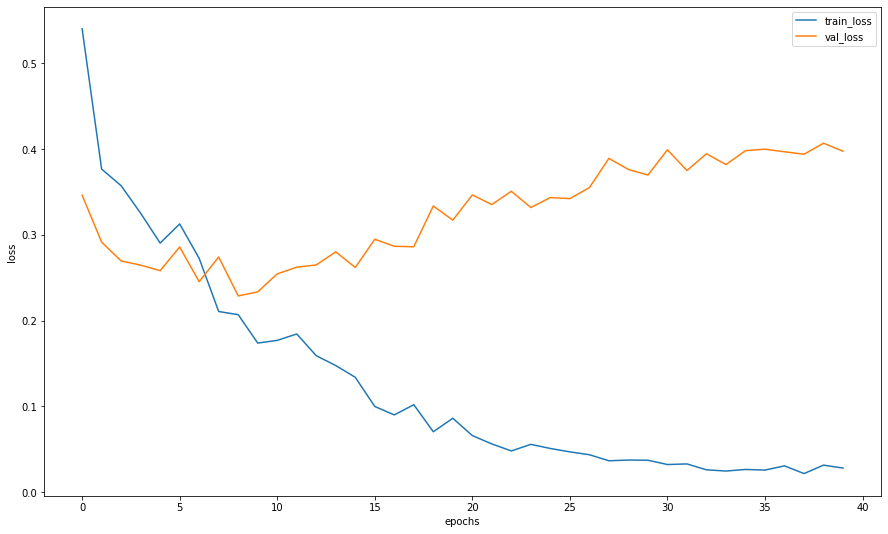

In [19]:
#смотрим на то ,как обучалась модель
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

In [20]:
np.max(val_acc)

tensor(0.9015, device='cuda:0', dtype=torch.float64)

# Портируем модель в .pt

In [0]:
model_extractor.eval()
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_extractor, example.cuda())
traced_script_module.save("/content/gdrive/My Drive/Resnet18_0.9028_2_224_v3_Tiptiuk_Nikita.pt")

# Предсказывания 
Тут был сабмит на кагл .Убирать не стал ,вдруг кому интересно 

In [0]:
test_files = (list([Path("/content/data/test/benign/1.jpg")]))
test_dataset = MoleDataset(test_files, mode="test")

In [0]:
test_loader = DataLoader(test_dataset , shuffle=False, batch_size=1)
predict(model_extractor,test_loader)
print(labels.to(DEVICE))

In [0]:
test_dataset = MoleDataset(test_files, mode="test")
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

my_submit.to_csv('/content/gdrive/My Drive/simpson_dataset/simple4_cnn_baseline.csv', index=False)

# f1 score
Заготовочка под f1 score.+ Первая фунция используется в следующем блоке

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [0]:
random_characters = int(np.random.uniform(0,300))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

In [0]:
idxs = list(map(int, np.random.uniform(0,6, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [164]:
actual_labels

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class)

# imshow
Посмотрим на то ,с какой вероятностью и что предсказывает модель

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

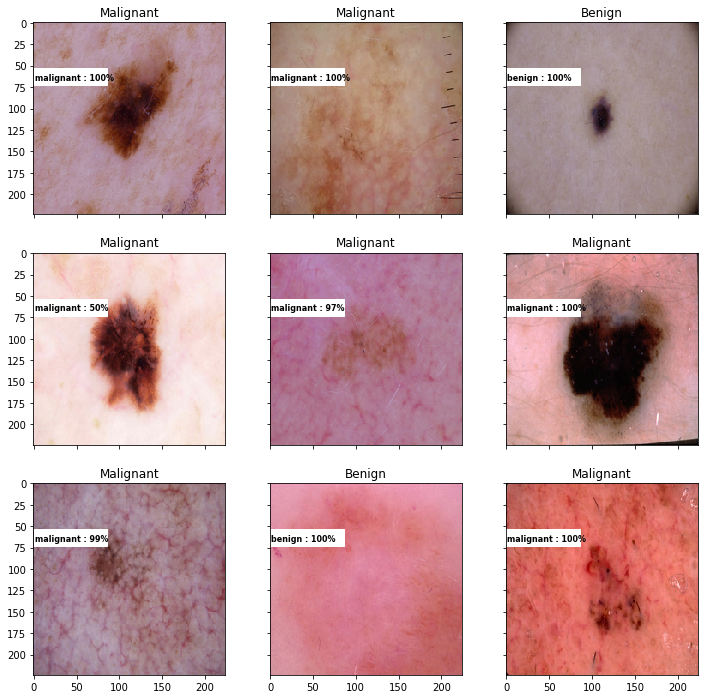

In [25]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12),sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,300))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(),title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,20,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_extractor, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [0]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)